<a href="https://colab.research.google.com/github/gamesMum/ChineseSignsClassification/blob/master/Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **The Zodiac Chinese Challenge**

## **Prepare Tha Data**

In [1]:
#Download data from kaggle
import os
os.environ['KAGGLE_USERNAME'] = "rashasalim" # username from the json file
os.environ['KAGGLE_KEY'] = "eacad49a0c7d1afc1988a7907a39dca8" # key from the json file
!kaggle datasets download -d elderyouth/chinese-zodiac-signs # api copied from kaggle

 99% 2.06G/2.07G [00:27<00:00, 42.7MB/s]
100% 2.07G/2.07G [00:28<00:00, 79.1MB/s]


- Unzip the file:



In [8]:
#unzip the folder downloaded from kaggle
!unzip chinese-zodiac-signs.zip

Archive:  chinese-zodiac-signs.zip
  inflating: signs/test/dog/00000004.jpg  
  inflating: signs/test/dog/00000005.jpg  
  inflating: signs/test/dog/00000010.jpg  
  inflating: signs/test/dog/00000011.jpg  
  inflating: signs/test/dog/00000038.jpg  
  inflating: signs/test/dog/00000039.jpg  
  inflating: signs/test/dog/00000144.jpeg  
  inflating: signs/test/dog/00000164.jpg  
  inflating: signs/test/dog/00000165.jpg  
  inflating: signs/test/dog/00000167.jpg  
  inflating: signs/test/dog/00000170.jpg  
  inflating: signs/test/dog/00000173.jpg  
  inflating: signs/test/dog/00000206.jpg  
  inflating: signs/test/dog/00000207.jpg  
  inflating: signs/test/dog/00000212.jpg  
  inflating: signs/test/dog/00000213.jpg  
  inflating: signs/test/dog/00000359.jpg  
  inflating: signs/test/dog/00000365.jpg  
  inflating: signs/test/dog/00000366.jpg  
  inflating: signs/test/dog/00000371.jpg  
  inflating: signs/test/dog/00000372.jpg  
  inflating: signs/test/dog/00000373.jpg  
  inflating: signs

- Use nonechuck lobrary to use only the goog image files

In [3]:
#Download nonchuks library to remove corrupted images
!pip install nonechucks

  Created wheel for nonechucks: filename=nonechucks-0.4.0-cp36-none-any.whl size=11546 sha256=e29795546b43a6b08d9aaa6f8b5c1f3fcad86fc9da3bb08cc50910c731f007ae
  Stored in directory: /root/.cache/pip/wheels/00/b3/4e/4e30d5f934293de9abab2bfe6a4ce6fe77bf936c625133dd9c
Successfully built nonechucks


- import the necessary libraries

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np

import matplotlib.pyplot as plt

import nonechucks as nc
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


nonechucks may not work properly with this version of PyTorch (1.3.1). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Define transforms, rezise, rotate slightly, preform horizontal flip

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
data_dir = 'signs'

batch_size = 8

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((250, 250)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize((250, 250)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder('signs/train', transform=train_transforms)
valid_data = datasets.ImageFolder('signs/valid', transform=train_transforms)
test_data = datasets.ImageFolder('signs/test', transform=test_transforms)

train_data = nc.SafeDataset(train_data)
test_data = nc.SafeDataset(test_data)
valid_data = nc.SafeDataset(valid_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

print('patch_size: ', batch_size)
print('length of train dataset: ', len(train_data))
print('length of test dataset: ',len(test_data))
print('length of valid dataset: ',len(valid_data))
# specify the image classes
classes = ['dog', 'dragon', 'goat', 'horse', 'monkey', 'ox', 'pig', 'rabbit', 
           'ratt', 'rooster', 'snake', 'tiger']

patch_size:  8
length of train dataset:  7197
length of test dataset:  660
length of valid dataset:  650


### Visualize a Batch of Training Data

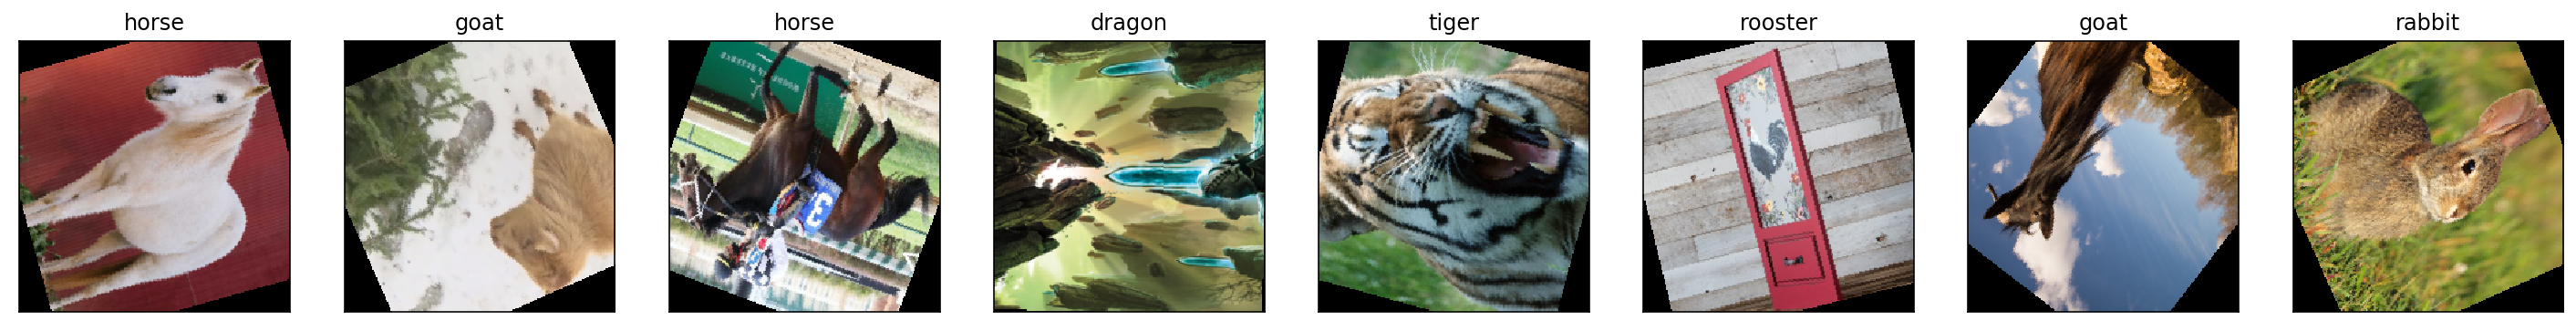

In [10]:
def imshow(img):
  img = img /2+0.5 #unormalize the images
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert it back from tensor to image

#get one batch of training images
dataiter = iter(train_loader) #now contains the first batch
images, labels = dataiter.next() #images=the first batch of images, labels= the first batch of labels
images = images.numpy() #convert the images to display them

#plot the imahes in the batch along with the corresponding labels
fig = plt.figure(figsize=(25,6))
#display 8 images
for idx in np.arange(batch_size):
  ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[]) #(rows, cols, index, .., ..)
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])



# **Build The Model**

In [17]:
import torch.nn as nn
import torch.nn.functional as FF

#Define the CNN architecture
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      # convolutional layer (sees 224 * 224 * 5 image tensor)
      self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
      # convolutional layer (sees 112 * 112 * 16 tensor)
      self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
      # convolutional layer (sees 56 * 56 * 32 tensor)
      self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
      # convolutional layer (sees 28 * 28 * 64 tensor)
      self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
      # convolutional layer (sees 14 * 14 * 128 tensor)
      self.conv5 = nn.Conv2d(128, 256, 5, padding=2)
      # max pooling layer
      self.pool = nn.MaxPool2d(2, 2)
      # linear layer (256 * 7 * 7 -> 500)
      self.fc1 = nn.Linear(256*7*7, 500)
      # linear layer (500 -> 12)
      self.fc2 = nn.Linear(500, 12)
      # dropout layer (p=0.25)
      self.dropout = nn.Dropout(0.25)
  
  def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        # flatten image input
        x = x.view(-1, 256*7*7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
         # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=12, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Define the optimizer and the error function

In [0]:
import torch.optim as optim
#the loss function
criterion = nn.CrossEntropyLoss()

#the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **Training**

In [0]:
# number of epochs to train the model
import numpy as np
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss (comapre the values of the output model to the actual labels)
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_signs.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [0]:
model.load_state_dict(torch.load('model_signs.pt'))

# **Test our model**

In [0]:
#initialize the test loss
test_loss = 0.0
#set the model to test and validation mode (no gradient descent needed)
model.eval()
for images, labels in test_loader:
  #move the tensor to GPU ig available
  if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()
  #forward pass: compute prediction output by passing the first batch of test data
  output = model(images)
  #calculate the batch size
  loss = criterion(output, labels)
  #update the test loss
  test_loss += loss.item()*images.size(0)
  #convert output probabilities to output class
  _, pred = torch.max(output, 1)
  #compare the prediction to true label
  correct_tensor = pred.eq(labels.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
   # calculate test accuracy for each object class

